# Borealis Dataset – Structural Exploration and Trials

This notebook documents the **exploratory phase** of working with the **Borealis "03 - CONSTANT CURRENT" dataset**  
([DOI: 10.5683/SP3/UYPYDJ](https://borealisdata.ca/dataset.xhtml?persistentId=doi:10.5683/SP3/UYPYDJ)).

It contains exploratory code and trials. It is preserved here for traceability and learning.

## 1. Setup & Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import interpolate

## 2. Cycle Folder Parsing

- Each cycle is stored in a **separate folder** named like `Cycle 0000`, `Cycle 0145`, etc.  
- Inside each folder, there is **exactly one `.xlsx` file** named in the format:  
  `CC_<protocol_label>_Channel_5_Wb_1.xlsx`  
  (e.g. `five`, `ten`, `baseline`, etc.)

Thanks to this consistent structure, the parser below:
- Iterates through all `Cycle XXXX` folders (sorted numerically)
- Automatically detects the `.xlsx` file inside
- Builds a clean `{cycle_number: file_path}` dictionary  

This enables **batch processing** without hardcoding filenames.

In [2]:
from pathlib import Path

# Set base path: adapt as needed depending on actual working directory
current_dir = os.getcwd()
base_path = Path(os.path.join(
    current_dir,
    '..', 'Data', 'raw_data',
    '03-CONSTANT CURRENT protocol_Cycles 0 to 1000',
))

# Prepare a dictionary to store mappings: {cycle_number: file_path}
cycle_file_map = {}

# Loop through "Cycle XXXX" folders, sorted numerically by the number at the end
for cycle_folder in sorted(base_path.glob("Cycle *"), key=lambda p: int(p.name.split()[-1])):
    if cycle_folder.is_dir():
        cycle_number = int(cycle_folder.name.replace("Cycle ", ""))  # e.g., 'Cycle 0012' → 12

        # Get the .xlsx file inside the folder
        xlsx_files = list(cycle_folder.glob("*.xlsx"))
        if len(xlsx_files) == 0:
            print(f"[Warning] No .xlsx file found in {cycle_folder}")
            continue

        # Assume exactly one file per folder
        file_path = xlsx_files[0]
        cycle_file_map[cycle_number] = file_path

In [3]:
# To check if it works
print(cycle_file_map[0])

D:\FUSE 2025 SUM\battery-analysis-project\Notebooks\..\Data\raw_data\03-CONSTANT CURRENT protocol_Cycles 0 to 1000\Cycle 0000\CC_one_Channel_5_Wb_1.xlsx


## 3. Paths & Column Mappings

Create subdirectories for saving outputs (plots and processed segments), and define standard variable names for columns in the raw `.xlsx` files.

In [4]:
# Construct the file path of outputs
output_plot_path = os.path.join(current_dir, '..', 'Plots', 'differential_curves')
output_data_path = os.path.join(current_dir, '..', 'Data', 'monotonic_segments')

# Make the folders if they don't exist to avoid error
os.makedirs(output_plot_path, exist_ok=True)
os.makedirs(output_data_path, exist_ok=True)

In [5]:
# Link variables to columns names used in your dataframe
I = 'Current(A)'
V = 'Voltage(V)'
Qc = 'Charge_Capacity(Ah)'
Qd = 'Discharge_Capacity(Ah)'
Ec = 'Charge_Energy(Wh)'
Ed = 'Discharge_Energy(Wh)'
dqdv = 'dQ/dV(Ah/V)'
dvdq = 'dV/dQ(V/Ah)'
T = 'Test_Time(s)'

dqdv_int = "Interpolated dQ/dV (Ah/V)"
dvdq_int = "Interpolated dV/dQ (V/Ah)"

## 4. Data Inspection (Optional)

In this section, users can manually inspect raw voltage/current/capacity/time profiles to help locate valid cycle segments for further processing.

In [6]:
# first randomly selected file
df1 = pd.read_excel(r"D:\FUSE 2025 SUM\battery-analysis-project\Data\raw_data\03-CONSTANT CURRENT protocol_Cycles 0 to 1000\Cycle 0000\CC_one_Channel_5_Wb_1.xlsx")

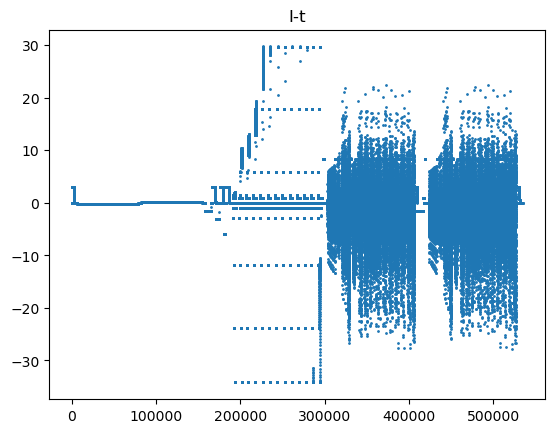

In [7]:
plt.plot(df1[T], df1[I], linestyle = 'none', marker= 'o', markersize=1)
plt.title('I-t')
plt.show()

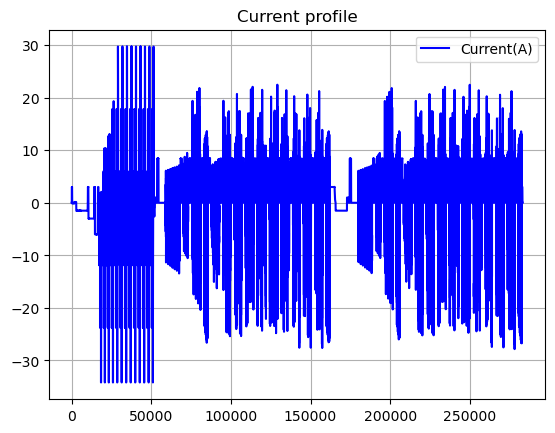

In [8]:
plt.plot(df1[I], label='Current(A)', color='blue')
plt.title("Current profile")
plt.legend()
plt.grid()
plt.show()

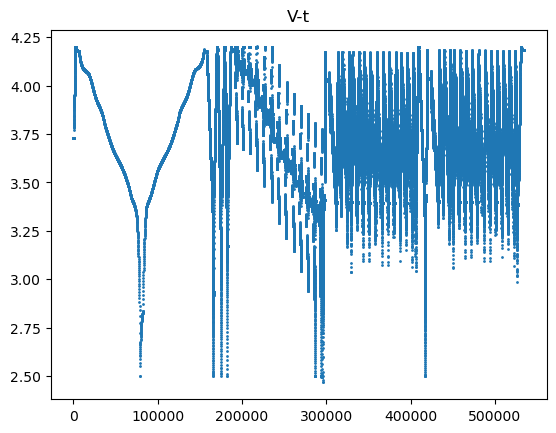

In [9]:
plt.plot(df1[T], df1[V], linestyle = 'none', marker= 'o', markersize=1)
plt.title('V-t')
plt.show()

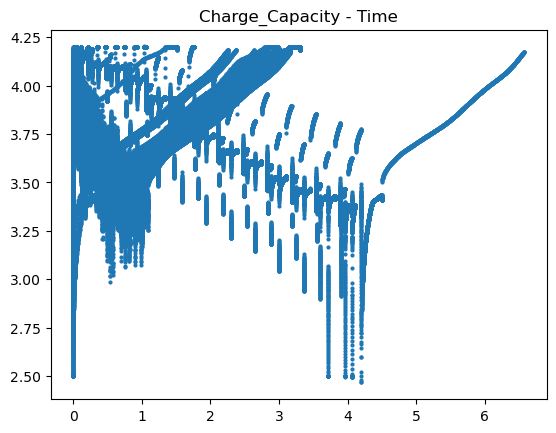

In [10]:
plt.plot(df1[Qc], df1[V], linestyle = 'none', marker= 'o', markersize=2)
plt.title('Charge_Capacity - Time')
plt.show()

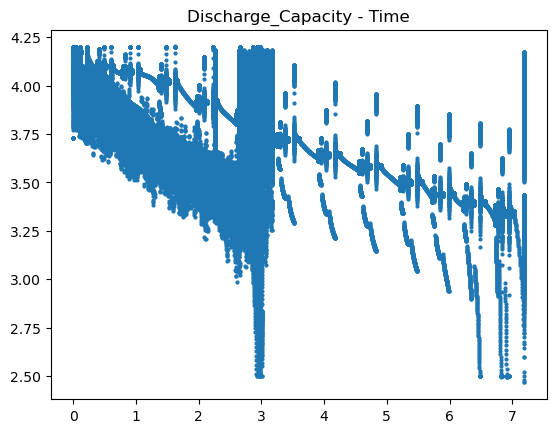

In [11]:
plt.plot(df1[Qd], df1[V], linestyle = 'none', marker= 'o', markersize=2)
plt.title('Discharge_Capacity - Time')
plt.show()

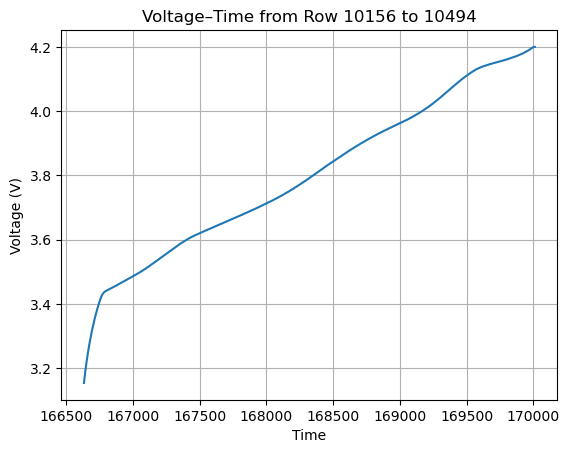

In [13]:
# magnify regions of interest (V-t)
start_row = 10155
end_row = 10494
df_slice = df1.iloc[start_row:end_row]
x = df_slice[T]
y = df_slice[V]
plt.plot(x, y)
plt.xlabel("Time")
plt.ylabel("Voltage (V)")
plt.title(f"Voltage–Time from Row {start_row+1} to {end_row}")
plt.grid(True)
plt.show()

In [14]:
# magnify regions of interest (I-t)
start_row = 25000
end_row = 35000
df_slice = df1.iloc[start_row:end_row]
x = df_slice[T]
y = df_slice[I]
plt.plot(x, y)
plt.xlabel("Time")
plt.ylabel("Current (I)")
plt.title(f"Current–Time from Row {start_row+1} to {end_row}")
plt.grid(True)
plt.show()

NameError: name 't' is not defined

In [ ]:
# second randomly selected file
df27 = pd.read_excel(
    r"D:\FUSE 2025 SUM\battery-analysis-project\Data\raw_data\03-CONSTANT CURRENT protocol_Cycles 0 to 1000\Cycle 0970\CC_twenty_seven_Channel_5_Wb_1.xlsx")

In [ ]:
plt.plot(df27[T], df27[V], linestyle='none', marker='o', markersize=1)
plt.title('V-t')
plt.show()

In [ ]:
plt.plot(df27[Qc], df27[V], linestyle = 'none', marker= 'o', markersize=1)
plt.title('Charge_Capacity - Voltage')
plt.show()

### Comparison with Original Dataset Derivatives

To investigate how the original `dV/dQ` and `dQ/dV` columns in the dataset were generated,  
we first tried recomputing `dV/dQ` using `np.gradient()` on the **raw** capacity and voltage values  
over a small row range (e.g. rows 10157–10180), and compared the result to the dataset column.

In [71]:
def calculate_dvdq(df, start_row, end_row):
    """
    Calculate dV/dQ over a specified row range.
    """
    segment = df.iloc[start_row:end_row].copy()
    
    q = segment[Qc].values
    v = segment[V].values

    dVdQ = np.gradient(v, q)
    
    result = pd.DataFrame({
        'dV/dQ': dVdQ
    })

    return result

In [72]:
# Calculate dV/dQ from voltage and capacity
computed_dvdq = calculate_dvdq(df1, start_row=10157, end_row=10180)
print("Computed dV/dQ:")
print(computed_dvdq)

# Compare to original dataset values
print("\nOriginal dataset column:")
print(df1[dvdq].iloc[10157:10180])

,dV/dQ
0,3.303700
1,3.153189
2,2.846353
3,2.600267
4,2.390003
5,2.197900
6,2.036058
7,1.891879
8,1.759394
9,1.609524


#### Observation:
The values didn’t match at all — even with correct alignment and spacing. That suggested the dataset’s derivatives probably weren’t computed using a basic numerical gradient on raw Q–V data.

To dig deeper, I tried several alternative methods in the main analysis notebook:

- Computing `np.gradient()` on smoothed Q–V curves (with deduplication)
- Computing `np.gradient()` on interpolated and smoothed Q–V curves (with deduplication)
- Estimating DCS using integrated current (I·dt) and smoothed voltage

All three gave clean, interpretable results, and the **shapes of the plots** looked quite similar to the original columns —  
but the **exact numerical values still didn’t match**.

Based on that, I suspect the original `dV/dQ` and `dQ/dV` columns were generated **on-device**,  
probably using internal firmware or a built-in smoothing/derivative algorithm during cycling.

So for my analysis going forward, I stick with the computed versions — they’re reproducible, tunable,  
and give me full control across all cells and cycles.


## 5. Preprocessing Functions

These functions handle the separation of charge/discharge segments from raw data and apply Savitzky-Golay smoothing to the voltage.

They form the foundation of the cleaning pipeline before interpolation and differential calculation.

In [15]:
def smooth(df, name, window, polyorder):
    """
    Apply Savitzky-Golay filter to smooth the given column in a DataFrame.
    - window: int, must be odd and >= polyorder+2
    """
    df['Voltage_sm (V)'] = savgol_filter(df[name], window_length=window, polyorder=polyorder)
    return df

In [16]:
def separate_charge_discharge(cycle_df, cycle_id):
    # ---charge---
    charge_df = cycle_df[cycle_df[I] > 0].copy()
    charge_df = charge_df[[I, T, V, Qc, dvdq, dqdv]].dropna(subset=[I, T, V, Qc]).reset_index(drop=True)
    charge_df = charge_df[charge_df[Qc] > 0].reset_index(drop=True)
    
    # ---discharge---
    discharge_df = cycle_df[cycle_df[I] < 0].copy()
    discharge_df = discharge_df[[I, T, V, Qd, dvdq, dqdv]].dropna().reset_index(drop=True)
    discharge_df = discharge_df[discharge_df[Qd] > 0].reset_index(drop=True)

    if charge_df.empty:
        print(f"[Cycle {cycle_id}] No charge data found.")
    if discharge_df.empty:
        print(f"[Cycle {cycle_id}] No discharge data found.")

    return charge_df, discharge_df

In [17]:
# Construct pure charge segment manually to feed into the function to see if it works
df1_charge_seg = df1.iloc[10155:10200]

In [18]:
print(df1_charge_seg[I].unique())

[2.9971 2.997  2.9967 2.9975 2.9981 2.9976 2.9973 2.9974 2.9977 2.9982
 2.9979 2.9965 2.9968 2.9984 2.9972]


In [19]:
def separate_test(cycle):
    # ---charge---
    charge_df = df1_charge_seg[df1_charge_seg[I] > 0].copy()
    charge_df = charge_df[[V, Qc, dvdq, dqdv]].dropna().reset_index(drop=True)
    charge_df = charge_df[charge_df[Qc] > 0].reset_index(drop=True)
    
    #---discharge---
    discharge_df = df1_charge_seg[df1_charge_seg[I] < 0].copy()
    discharge_df = discharge_df[[V, Qd, dvdq, dqdv]].dropna().reset_index(drop=True)
    discharge_df = discharge_df[discharge_df[Qd] > 0].reset_index(drop=True)
    
    if charge_df.empty:
        print(f"[Cycle {cycle}] No charge data found.")
    if discharge_df.empty:
        print(f"[Cycle {cycle}] No discharge data found.")
    
    return charge_df, discharge_df
separate_test(0)

[Cycle 0] No discharge data found.


(    Voltage(V)  Charge_Capacity(Ah)  dV/dQ(V/Ah)  dQ/dV(Ah/V)
 0       3.1540             0.024975      4.85720      0.21197
 1       3.1896             0.033301      4.13980      0.24687
 2       3.2208             0.041626      3.61600      0.27793
 3       3.2483             0.049950      3.24280      0.30985
 4       3.2733             0.058276      2.98700      0.35625
 5       3.2957             0.066603      2.75080      0.36475
 6       3.3166             0.074928      2.53580      0.41157
 7       3.3355             0.083256      2.31720      0.44623
 8       3.3532             0.091580      2.15410      0.47647
 9       3.3694             0.099906      1.94070      0.51124
 10      3.3847             0.108230      1.87820      0.55574
 11      3.3987             0.116560      1.67420      0.61181
 12      3.4115             0.124880      1.59000      0.64845
 13      3.4227             0.133210      1.43440      0.71014
 14      3.4308             0.141540      1.19430      

In [20]:
def separate_cycle(df, min_seg_length, min_v_variation):
    
    valid_cycles = []
    
    for cycle_id, cycle_df in df.groupby('Cycle_Index'):
        print(f"Processing Cycle {cycle_id}:")

        charge_df, discharge_df = separate_charge_discharge(cycle_df, cycle_id)
        
        # leave only valid cycles
        if charge_df.empty or discharge_df.empty:
            print("Skipped — missing charge or discharge")
            continue

        if len(charge_df) < min_seg_length or len(discharge_df) < min_seg_length:
            print("Skipped — segment too short")
            continue

        if charge_df["Voltage(V)"].nunique() < min_v_variation:
            print("Skipped — voltage variation too small")
            continue

        print(f"Valid Cycle {cycle_id} — ready for analysis")
        valid_cycles.append({
            "cycle_id": cycle_id,
            "charge_df": charge_df,
            "discharge_df": discharge_df
        })

    return valid_cycles

In [21]:
# test
separate_cycle(df1, 10, 5)

Processing Cycle 1:
Valid Cycle 1 — ready for analysis
Processing Cycle 2:
[Cycle 2] No charge data found.
Skipped — missing charge or discharge
Processing Cycle 3:
Valid Cycle 3 — ready for analysis
Processing Cycle 4:
Skipped — segment too short
Processing Cycle 5:
Valid Cycle 5 — ready for analysis


[{'cycle_id': 1,
  'charge_df':       Current(A)  Test_Time(s)  Voltage(V)  Charge_Capacity(Ah)  dV/dQ(V/Ah)  \
  0        2.99800      910.2463      3.7724             0.008325      2.48290   
  1        2.99710      920.2458      3.7791             0.016653      1.05510   
  2        2.99780      930.2466      3.7841             0.024982          NaN   
  3        2.99780      940.2458      3.7881             0.033309      0.57136   
  4        2.99720      950.2461      3.7917             0.041638          NaN   
  ...          ...           ...         ...                  ...          ...   
  1429     0.14998   154781.2032      4.1811             3.004700      0.00000   
  1430     0.14998   154841.2033      4.1830             3.007200          NaN   
  1431     0.14997   154901.2030      4.1848             3.009700      0.00000   
  1432     0.14998   154961.2037      4.1868             3.012200      0.77876   
  1433     0.14998   154972.9164      4.1874             3.012700   

## 6. Interpolation & Differential Curve Processing

We interpolate V–Q curves from the cleaned charge/discharge segments, and compute smoothed differential metrics `dV/dQ` and `dQ/dV` using cubic interpolation.

In [22]:
def process_single(charge_df, discharge_df, no_points, window, polyorder):
    # ---charge---
    x = charge_df[Qc] - charge_df[Qc].min()
    v = charge_df[V]
    dVdQ = charge_df[dvdq]
    dQdV = charge_df[dqdv]
    x, v, dVdQ, dQdV = map(np.array, (x, v, dVdQ, dQdV))
    _, idx = np.unique(x, return_index=True)
    x, v, dVdQ, dQdV = x[idx], v[idx], dVdQ[idx], dQdV[idx]

    f_v = interpolate.interp1d(x, v, kind='cubic', fill_value="extrapolate")
    f_dvdq = interpolate.interp1d(x, dVdQ, kind='cubic', fill_value="extrapolate")
    f_dqdv = interpolate.interp1d(x, dQdV, kind='cubic', fill_value="extrapolate")
    z = np.linspace(x.min(), x.max(), no_points)

    df_charge = pd.DataFrame({
        Qc: z,
        "Interpolated Voltage (V)": f_v(z),
        "Interpolated dV/dQ (V/Ah)": f_dvdq(z),
        "Interpolated dQ/dV (Ah/V)": f_dqdv(z)
    })
    df_charge = smooth(df_charge, "Interpolated Voltage (V)", window, polyorder)

    # ---discharge---
    x = discharge_df[Qd] - discharge_df[Qd].min()
    v = discharge_df[V]
    dVdQ = discharge_df[dvdq]
    dQdV = discharge_df[dqdv]
    x, v, dVdQ, dQdV = map(np.array, (x, v, dVdQ, dQdV))
    _, idx = np.unique(x, return_index=True)
    x, v, dVdQ, dQdV = x[idx], v[idx], dVdQ[idx], dQdV[idx]

    f_v = interpolate.interp1d(x, v, kind='cubic', fill_value="extrapolate")
    f_dvdq = interpolate.interp1d(x, dVdQ, kind='cubic', fill_value="extrapolate")
    f_dqdv = interpolate.interp1d(x, dQdV, kind='cubic', fill_value="extrapolate")
    z = np.linspace(x.min(), x.max(), no_points)

    df_discharge = pd.DataFrame({
        Qd: x.max() - z,
        "Interpolated Voltage (V)": f_v(z),
        "Interpolated dV/dQ (V/Ah)": f_dvdq(z),
        "Interpolated dQ/dV (Ah/V)": f_dqdv(z)
    })
    df_discharge = smooth(df_discharge, "Interpolated Voltage (V)", window, polyorder)

    return df_charge, df_discharge

In [23]:
def process_all():

    processed = []
    
    valid_cycles = separate_cycle(df, min_seg_length, min_v_variation)
    
    for entry in valid_cycles:
        cycle_id = entry['cycle_id']
        charge_df = entry['charge_df']
        discharge_df = entry['discharge_df']

        df_charge, df_discharge = process_single(charge_df, discharge_df, no_points, window, polyorder)

        processed.append({
            "cycle_id": cycle_id,
            "df_charge": df_charge,
            "df_discharge": df_discharge
        })

    return processed

## 7. Plotting and Monotonic Region Selection

This section provides tools for visualizing processed charge/discharge cycles, selecting valid segments, and exporting clean regions for downstream differential analysis.

The workflow is:
1. Use `plot_vq()` to visually inspect full charge/discharge V–Q curves.
2. Use `save_monotonic_region()` to manually select a segment with monotonic Q–V behavior (by eye).
3. Use `plot_monotonic_qv()` to verify saved region.

This segment can then be used as clean input to:
- Plot the original `dQ/dV`, `dV/dQ` curves from the dataset.
- Compute new differential curves using `np.gradient`.

This step is essential for isolating a well-behaved portion of the cycle for consistent comparisons between methods.

In [24]:
def plot_vq(cycle_no, process='charge', **kwargs):
    
    processed = process_all()
    target_cycle = cycle_no

    for entry in processed:
        if entry['cycle_id'] == target_cycle:
            charge_df = entry['df_charge']
            discharge_df = entry['df_discharge']
            break
    else:
        print(f"Cycle {target_cycle} not found.")
        return
    
    if process == 'charge':   
        df = charge_df
        q = df[Qc]
        v = df['Voltage_sm (V)']
        default_label = 'Charge V–Q curve'
        
    elif process == 'discharge':
        df = discharge_df
        q = df[Qd]
        v = df['Voltage_sm (V)']
        default_label = 'Discharge V–Q curve'
    else:
        raise ValueError("process must be 'charge' or 'discharge'")

    # Auto-set label if not provided
    if 'label' not in kwargs:
        kwargs['label'] = f"{default_label} (Cycle {cycle_no})"

    # Plot
    plt.plot(q, v, **kwargs)
    plt.xlabel("Capacity (Ah)")
    plt.ylabel("Smoothed Voltage (V)")
    plt.title(f"{default_label} from Cycle {cycle_no}")
    plt.grid(True)
    plt.legend()
    plt.show()

In [25]:
cycle_folder = 595
df = pd.read_excel(cycle_file_map[cycle_folder])

In [26]:
cycle_no = 1
window = 15
polyorder = 3
min_seg_length, min_v_variation = 10, 5
no_points = 10001
eps = 1e-6

Processing Cycle 1:
Valid Cycle 1 — ready for analysis
Processing Cycle 2:
[Cycle 2] No charge data found.
Skipped — missing charge or discharge
Processing Cycle 3:
Skipped — segment too short
Processing Cycle 4:
[Cycle 4] No charge data found.
Skipped — missing charge or discharge
Processing Cycle 5:
Valid Cycle 5 — ready for analysis
Processing Cycle 6:
[Cycle 6] No charge data found.
Skipped — missing charge or discharge
Processing Cycle 7:
Skipped — segment too short
Processing Cycle 8:
[Cycle 8] No charge data found.
Skipped — missing charge or discharge
Processing Cycle 9:
Valid Cycle 9 — ready for analysis


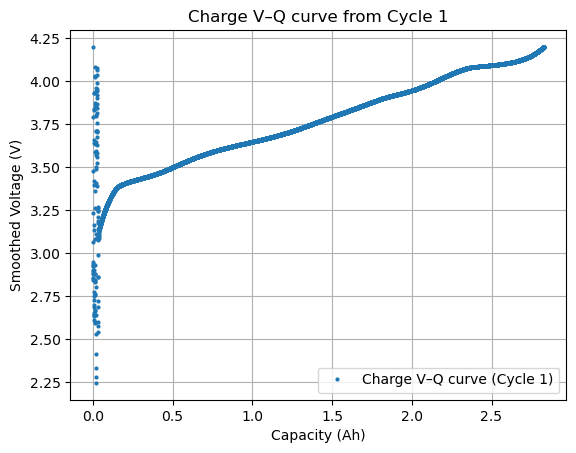

In [27]:
plot_vq(1, process='charge', linestyle = 'none', marker= 'o', markersize=2)

In [28]:
# select monotonic region (by eye...) and store as processed data for differential analysis
def save_monotonic_region(cycle_no, q_min, q_max, process='charge'):
    data = process_all()
    target_cycle = cycle_no

    for entry in data:
        if entry['cycle_id'] == target_cycle:
            charge_df = entry['df_charge']
            discharge_df = entry['df_discharge']
            break

    if process == "charge":
        df = charge_df
        q_col = Qc
    elif process == "discharge":
        df = discharge_df
        q_col = Qd
    else:
        raise ValueError("process must be 'charge' or 'discharge'")
    
    v_col = "Voltage_sm (V)"
    
    q = df[q_col]
    v = df[v_col]

    mask = (q>=q_min) & (q<=q_max)
    region = df.loc[mask, [q_col, v_col, "Interpolated dV/dQ (V/Ah)", "Interpolated dQ/dV (Ah/V)"]].copy()
    
    # Save file with naming format like: preprocessed_cycle3_charge.csv
    save_name = f"preprocessed_cycle{cycle_no}_{process}.csv"
    save_path = os.path.join(output_data_path, save_name)
    region.to_csv(save_path, index=False)
    print(f"Saved to: {save_path}")

In [29]:
save_monotonic_region(1, 0.05, 2.6, process ='charge')

Processing Cycle 1:
Valid Cycle 1 — ready for analysis
Processing Cycle 2:
[Cycle 2] No charge data found.
Skipped — missing charge or discharge
Processing Cycle 3:
Skipped — segment too short
Processing Cycle 4:
[Cycle 4] No charge data found.
Skipped — missing charge or discharge
Processing Cycle 5:
Valid Cycle 5 — ready for analysis
Processing Cycle 6:
[Cycle 6] No charge data found.
Skipped — missing charge or discharge
Processing Cycle 7:
Skipped — segment too short
Processing Cycle 8:
[Cycle 8] No charge data found.
Skipped — missing charge or discharge
Processing Cycle 9:
Valid Cycle 9 — ready for analysis
Saved to: D:\FUSE 2025 SUM\battery-analysis-project\Notebooks\..\Data\monotonic_segments\preprocessed_cycle1_charge.csv


In [30]:
# Construct a way to parse process_data folder
current_dir = os.getcwd()
base_path = Path(os.path.join(current_dir, '..', 'Data', 'monotonic_segments')).resolve()

def get_file_path(cycle_id, process, base_path):
    """
    Given a cycle number and process name ('charge' or 'discharge'),
    return the full file path for that file in processed_data folder.
    """
    filename = f"preprocessed_cycle{cycle_id}_{process}.csv"
    full_path = os.path.join(base_path, filename)

    if Path(full_path).exists():
        return str(full_path)
    else:
        raise FileNotFoundError(f"File not found: {full_path}")

In [31]:
def plot_monotonic_qv(cycle_no, process, **kwargs):
    path = get_file_path(cycle_no, process, base_path)
    df = pd.read_csv(path)
    
    if process == 'charge':   
        q = df[Qc]
        v = df['Voltage_sm (V)']
        default_label = 'Charge V–Q curve'
        
    elif process == 'discharge':
        q = df[Qd]
        v = df['Voltage_sm (V)']
        default_label = 'Discharge V–Q curve'
    else:
        raise ValueError("Process must be 'charge' or 'discharge'.")

    # Auto-set label if not provided
    if 'label' not in kwargs:
        kwargs['label'] = f"{default_label} (Cycle {cycle_no})"

    # Plot
    plt.plot(q, v, **kwargs)
    plt.xlabel("Capacity (Ah)")
    plt.ylabel("Smoothed Voltage (V)")
    plt.title(f"{default_label} from Cycle {cycle_no}")
    plt.grid(True)
    plt.legend()
    plt.show()

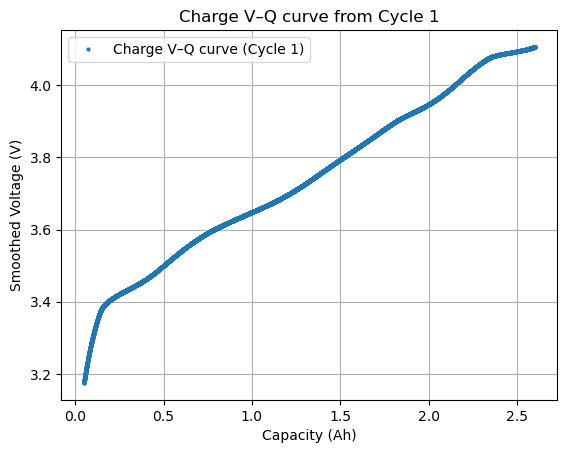

In [32]:
plot_monotonic_qv(1, process='charge', linestyle = 'none', marker= 'o', markersize=2)

## 8. Differential Plotting Methods

This section generates `dQ/dV` and `dV/dQ` plots from processed monotonic regions.

Two approaches are supported:
- `plot_derivative()` uses the raw `dQ/dV` or `dV/dQ` values provided in the original dataset.
- `plot_differential()` recalculates the differential curve using `np.gradient` on the smoothed Q–V segment.

Both help assess differential signatures such as reaction peaks and plateaus, and allow comparison across preprocessing approaches.

In [33]:
# Derivatives directly from dataset
def plot_derivative(cycle_folder, cycle_no, process, mode, **kwargs):
    
    df = pd.read_excel(cycle_file_map[cycle_folder])
    valid_cycles = separate_cycle(df, min_seg_length, min_v_variation)
    
    for entry in valid_cycles:
        if entry['cycle_id'] == cycle_no:
            charge_df = entry['charge_df']
            discharge_df = entry['discharge_df']
            break
        else:
            print(f"Cycle {cycle_no} not found.")
            return
    
    if process == 'charge':
        df = charge_df
    elif process == 'discharge':
        df = discharge_df
    else:
        raise ValueError("Process must be 'charge' or 'discharge'.")
    
    df_dqdv = df[[V, dqdv]].dropna()
    df_dvdq = df[[V, dvdq]].dropna()
    
    if mode == 'dqdv':
        v = df_dqdv[V]
        plt.plot(v, df_dqdv[dqdv], label=f'dQ/dV (Cycle {cycle_no})', **kwargs)
        plt.xlabel("Voltage (V)")
        plt.ylabel("dQ/dV")
        plt.title("dQ/dV vs Voltage")
    elif mode == 'dvdq':
        v = df_dvdq[V]
        plt.plot(v, df_dvdq[dvdq], label=f'dV/dQ (Cycle {cycle_no})', **kwargs)
        plt.xlabel("Voltage (V)")
        plt.ylabel("dV/dQ")
        plt.title("dV/dQ vs Voltage")
    plt.legend()
    plt.grid(True)
    plt.show()

In [34]:
# Derivatives from np.gradient()
def plot_differential(cycle_no, eps, process = 'discharge', mode='dqdv', **kwargs):
    path = get_file_path(cycle_no, process, base_path)
    df = pd.read_csv(path)
    
    if process == 'charge':   
        q_col = Qc
    elif process == 'discharge':
        q_col = Qd 
    else:
        raise ValueError("process must be 'charge' or 'discharge'")
    
    if df.empty:
        print(f'Cycle {cycle_no} has no data to plot.')
        return 

    # Extract smoothed voltage and capacity
    v = df['Voltage_sm (V)']
    q = df[q_col]
    
    # Sort capacity and align voltage accordingly
    sort_idx = np.argsort(q)
    v = np.array(v)[sort_idx]
    q = np.array(q)[sort_idx]

    # Compute gradients
    dv = np.gradient(v)
    dq = np.gradient(q)

    # Filter out near-zero gradients to avoid division errors
    mask = np.abs(dv) > eps if mode == 'dqdv' else np.abs(dq) > eps
    v = v[mask]
    q = q[mask]
    dv = dv[mask]
    dq = dq[mask]
    
    # Compute the differential curve
    if mode == 'dvdq':
        y = dv / dq
        y_label = "dV/dQ"
    elif mode == 'dqdv':
        y = dq / dv
        y_label = "dQ/dV"
    else:
        raise ValueError("Mode must be 'dvdq' or 'dqdv'.")

    # Auto label if none provided
    if 'label' not in kwargs:
        kwargs['label'] = f"{y_label} ({process} cycle {cycle_no})"

    # Plot the curve
    plt.plot(v, y, **kwargs)
    plt.xlabel("Voltage (V)")
    plt.ylabel(y_label)
    plt.title(f"{y_label} curve from Cycle {cycle_no} ({process})")
    plt.grid(True)
    plt.legend()

Processing Cycle 1:
Valid Cycle 1 — ready for analysis
Processing Cycle 2:
[Cycle 2] No charge data found.
Skipped — missing charge or discharge
Processing Cycle 3:
Skipped — segment too short
Processing Cycle 4:
[Cycle 4] No charge data found.
Skipped — missing charge or discharge
Processing Cycle 5:
Valid Cycle 5 — ready for analysis
Processing Cycle 6:
[Cycle 6] No charge data found.
Skipped — missing charge or discharge
Processing Cycle 7:
Skipped — segment too short
Processing Cycle 8:
[Cycle 8] No charge data found.
Skipped — missing charge or discharge
Processing Cycle 9:
Valid Cycle 9 — ready for analysis


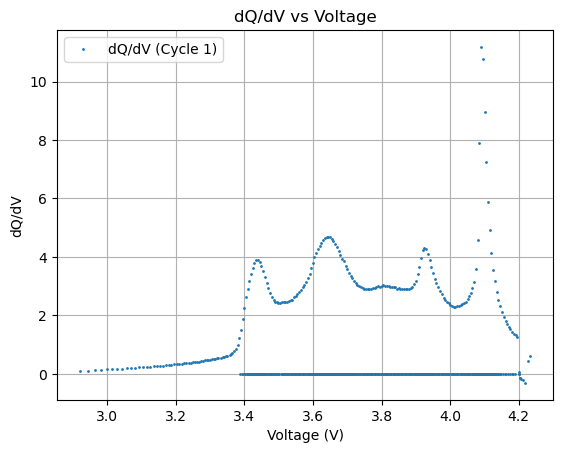

In [35]:
plot_derivative(cycle_folder=595, cycle_no = 1, process='charge', mode='dqdv', linestyle='none', marker='o', markersize=1)

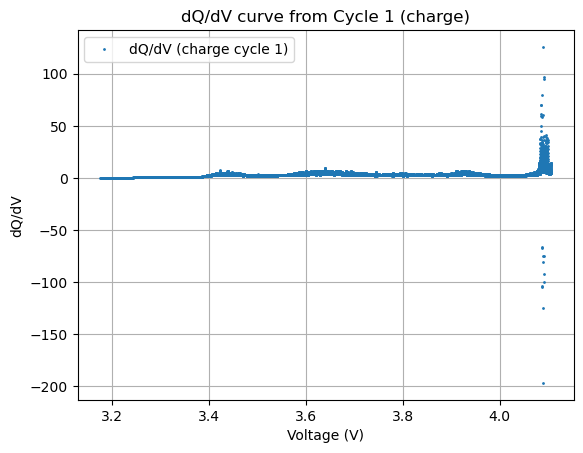

In [36]:
plot_differential(cycle_no=cycle_no, eps=eps, process='charge', mode='dqdv', linestyle='none', marker='o', markersize=1)

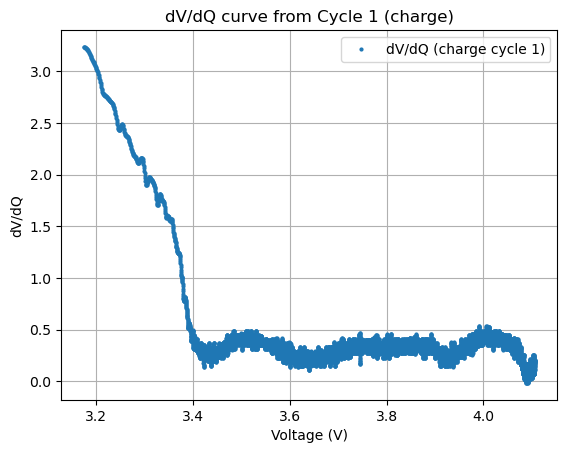

In [37]:
plot_differential(cycle_no=cycle_no, eps=eps, process='charge', mode='dvdq', linestyle='none', marker='o', markersize=2)

## 9. Differential Coulometry Spectroscopy (DCS)

This section computes DCS curves by integrating current over time to obtain charge Q(t),  
then calculating dQ/dV and plotting it against voltage.  

The approach is similar to `dQ/dV`, but uses time-domain integration instead of direct dataset columns.  
Useful for studying phase transitions and reaction slippage in aging cells.

In [38]:
def compute_dcs(cycle_folder, cycle_no, min_seg_length, min_v_variation, eps, process = 'charge'):
    
    df = pd.read_excel(cycle_file_map[cycle_folder])
    
    v_col = df[V]
    
    valid_cycles = separate_cycle(df, min_seg_length, min_v_variation)
    
    for entry in valid_cycles:
        if entry['cycle_id'] == cycle_no:
            df_charge = entry['df_charge']
            df_discharge = entry['df_discharge']
            break
    else:
        print(f"Cycle {cycle_no} not found.")
        return
    
    if process == 'charge':  
        df_charge = smooth(df_charge, v_col, window, polyorder)
        df = df_charge
    elif process == 'discharge':
        df_discharge = smooth(df_discharge, v_col, window, polyorder)
        df = df_discharge
    else:
        raise ValueError("process must be 'charge' or 'discharge'")
    
    t = df[T].values
    i = df[I].values
    
    dt = np.diff(t, prepend=t[0]) # prepend to ensure array lengths' consistency
    q = np.cumsum(i*dt) # integration
    v = df['Voltage_sm (V)'].values
    
    dv = np.gradient(v)
    dq = np.gradient(q)
    
    # Filter out near-zero gradients to avoid division errors
    mask = np.abs(dv) > eps
    v = v[mask]
    q = q[mask]
    dv = dv[mask]
    dq = dq[mask]
     
    # compute dQ/dV
    dqdv = dq/dv
    
    return v, dqdv

In [39]:
def plot_dcs(cycle_folder, cycle_no, min_seg_length, min_v_variation, eps, process, **kwargs):
    
    v, dqdv = compute_dcs(cycle_folder, cycle_no, min_seg_length, min_v_variation, eps, process)
    
    plt.plot(v, dqdv, **kwargs)
    plt.xlabel("Voltage (V)")
    plt.ylabel("dQ/dV (Ah/V)")
    plt.title(f"Differential Coulometry (DCS) from Cycle {cycle_no} during {process}")
    plt.grid(True)
    plt.show()

In [40]:
plot_dcs(cycle_folder=595, cycle_no = 1, min_seg_length=min_seg_length, min_v_variation=min_v_variation, eps=eps, process ='charge', linestyle='none', marker='o', markersize=1)

Processing Cycle 1:
Valid Cycle 1 — ready for analysis
Processing Cycle 2:
[Cycle 2] No charge data found.
Skipped — missing charge or discharge
Processing Cycle 3:
Skipped — segment too short
Processing Cycle 4:
[Cycle 4] No charge data found.
Skipped — missing charge or discharge
Processing Cycle 5:
Valid Cycle 5 — ready for analysis
Processing Cycle 6:
[Cycle 6] No charge data found.
Skipped — missing charge or discharge
Processing Cycle 7:
Skipped — segment too short
Processing Cycle 8:
[Cycle 8] No charge data found.
Skipped — missing charge or discharge
Processing Cycle 9:
Valid Cycle 9 — ready for analysis


KeyError: 'df_charge'